In [1]:
import os

import himalaya
import numpy as np
import pandas as pd
from himalaya.backend import set_backend
from himalaya.ridge import RidgeCV
from matplotlib import pyplot as plt
import seaborn as sns
import simplstyles
from sklearn.pipeline import make_pipeline
from voxelwise_tutorials.delayer import Delayer

from fmri.features import load_brain_data, load_feature

In [2]:
backend = set_backend("torch_cuda", on_error='throw')
plt.style.use('nord-light-talk')
data_dir = "../../data"

In [3]:
subject = 1
modality = "reading"
trim = 5

In [4]:
n_alphas_batch = 3
n_targets_batch = 100
n_targets_batch_refit = 50

In [5]:
number_of_delays = 4
alphas = np.logspace(-5, 20, 10)
n_iter = 25
cv = 5

In [6]:
def result_path(subject, modality, ridge_type, param_name, param_range):
    dir = f"results/brain_maps_validation_curves/{modality}/{subject}/{ridge_type}"
    os.makedirs(dir, exist_ok=True)
    path = os.path.join(dir, f"{param_name}_{param_range}.csv")
    return path

# Load features

In [7]:
X, n_samples_train = load_feature(data_dir, "english1000")

# Load brain data

In [8]:
Y, n_samples_train = load_brain_data(data_dir, subject, modality, trim)

/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack(

# CV

In [9]:
import math

cv_range = np.logspace(math.log(2.1, 10), math.log(50.1, 10), 9).astype(int)
cv_range

array([ 2,  3,  4,  6, 10, 15, 22, 33, 50])

In [10]:
cv_scores = pd.DataFrame()
for _cv in cv_range:
    print(_cv)
    path = result_path(subject, modality, "ridge", "cv", _cv)
    if not os.path.exists(path):
        print("File does not exist")
        delayer = Delayer(delays=range(1, number_of_delays + 1))
        solver_params = dict(
            n_targets_batch=n_targets_batch,
            n_targets_batch_refit=n_targets_batch_refit,
            score_func=himalaya.scoring.r2_score
        )
        ridge_cv = RidgeCV(alphas=alphas, cv=_cv, solver_params=solver_params)
        pipeline = make_pipeline(
            delayer,
            ridge_cv
        )
        pipeline.fit(X[:n_samples_train], Y[:n_samples_train])
        cv_score = pipeline[-1].cv_scores_
        prediction = pipeline.predict(X[n_samples_train:])
        prediction = backend.to_numpy(prediction)

        correlation = np.array([np.corrcoef(Y[n_samples_train:, i], prediction[:, i])[0, 1] for i in range(Y.shape[1])])

        r2 = himalaya.scoring.r2_score(Y[n_samples_train:], prediction)
        r2 = backend.to_numpy(r2)

        result = pd.DataFrame(
            {
                'cv_score': cv_score,
                'r2_score': r2,
                'correlation_score': correlation
            }
        )
        result.to_csv(path)
        cv_scores[f'cv_{_cv}'] = result['r2_score']
    else:
        print("File exists")
        result = pd.read_csv(path)
        # add new colum with _cv
        cv_scores[f'cv_{_cv}'] = result['r2_score']
cv_scores.head()

2
File exists
3
File exists
4
File exists
6
File exists
10
File exists
15
File exists
22
File exists
33
File does not exist


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 3887 < 3940). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/leo/PycharmPr

50
File does not exist


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 3887 < 3940). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/leo/PycharmPr

,cv_2,cv_3,cv_4,cv_6,cv_10,cv_15,cv_22,cv_33,cv_50
0,-inf,-inf,-inf,-5.795455e+14,-5.795455e+14,-5.795455e+14,-5.795455e+14,-5.984398e+36,-5.795455e+14
1,-2.444727e+14,-1.655397e+35,-2.444727e+14,-2.444727e+14,-2.444727e+14,-2.444727e+14,-2.444727e+14,-2.444727e+14,-2.444727e+14
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,-1.768217e+14,-1.768217e+14,-1.768217e+14,-1.768217e+14,-1.768217e+14,-1.768217e+14,-1.768217e+14,-1.768217e+14,-1.768217e+14


([<matplotlib.axis.XTick at 0x732d92341850>,
 [Text(0, 0, '2'),
  Text(1, 0, '3'),
  Text(2, 0, '4'),
  Text(3, 0, '6'),
  Text(4, 0, '10'),
  Text(5, 0, '15'),
  Text(6, 0, '22'),
  Text(7, 0, '33'),
  Text(8, 0, '50')])

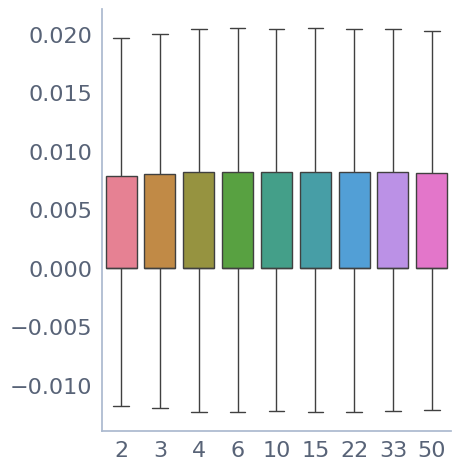

In [11]:
sns.catplot(data=cv_scores, kind='box', showfliers=False)
plt.xticks(np.arange(len(cv_range)),cv_range)